## Laboratorio Algorithmic Trading with Quantics



Universidad Nacional de Colombia

**Sara Isabel Ospina Valderrama**

#   Q18 Machine Learning Rolling Basis

In this example we predict whether the price will rise or fall by using supervised learning (Bayesian Ridge Regression). This template represents a starting point for developing a system which can take part to the **Q18
NASDAQ-100 Stock Long-Short contest**.

It consists of two parts.

* In the **first part** we just perform a global training of the time series using all time series data. We disregard the sequential aspect of the data and use also future data to train past data.

* In the **second part** we use the built-in backtester and perform training and prediction on a rolling basis in order to avoid forward looking. Please note that we are using a **specialized** version of the Quantiacs backtester which dramatically speeds up the the backtesting process by retraining your model on a regular basis.

**Features for learning**: we will use several technical indicators trying to capture different features. You can have a look at [**Technical Indicators**](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html).

Please note that:

* Your trading algorithm can open short and long positions.

* At each point in time your algorithm can trade all or a subset of the stocks which at that point of time are or were part of the NASDAQ-100 stock index. Note that the composition of this set changes in time, and Quantiacs provides you with an appropriate filter function for selecting them.

* The Sharpe ratio of your system since January 1st, 2006, has to be larger than 1.

* Your system cannot be a copy of the current examples. We run a correlation filter on the submissions and detect duplicates.

* For simplicity we will use a single asset. It pays off to use more assets, ideally uncorrelated, and diversify your positions for a more solid Sharpe ratio.

More details on the rules can be found [here](https://quantiacs.com/contest).

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.

**More help with Jupyter?** Check the official [**Jupyter**](https://jupyter.org/) page.

Once you are done, click on **Submit to the contest** and take part to our competitions.

API reference:

* **data**: check how to work with [data](https://quantiacs.com/documentation/en/reference/data_load_functions.html);

* **backtesting**: read how to run the [simulation](https://quantiacs.com/documentation/en/reference/evaluation.html) and check the results.

Need to use the optimizer function to automate tedious tasks?

* **optimization**: read more on our [article](https://quantiacs.com/community/topic/29/optimizing-and-monitoring-a-trading-system-with-quantiacs).

### 1. Explicaciones

1.   **Modelo:**El uso de un Decision Tree Regressor puede mejorar la predicción de precios al capturar relaciones no lineales entre las características, algo que un modelo lineal como la Regresión Lineal no puede hacer. En este caso, al limitar la profundidad del árbol (max_depth=5) se controla la complejidad del modelo, reduciendo el riesgo de sobreajuste y mejorando la capacidad de generalización. Además, el parámetro min_samples_split=10 asegura que haya suficientes datos en cada división para reducir la varianza en las predicciones. Este enfoque simplificado es ideal cuando se busca un modelo que ofrezca un equilibrio entre precisión y estabilidad, especialmente en contextos donde los datos pueden ser ruidosos o no lineales.
2.   **Assets:**Los 20 activos seleccionados representan una mezcla de industrias clave en el mercado de valores, incluyendo tecnología, comercio electrónico, biotecnología y semiconductores. Esta selección diversificada permite capturar patrones de comportamiento en diferentes sectores y reduce la probabilidad de sesgos sectoriales en el modelo. Además, incluir empresas con alta capitalización de mercado y volatilidad moderada puede mejorar la capacidad del modelo para generalizar y predecir precios con mayor precisión.
3. **Features:**Las nuevas características fueron elegidas para enriquecer la capacidad del modelo en la predicción de precios:

* Tasa de cambio logarítmica captura cambios relativos en el precio, lo que es útil para identificar patrones de retornos.
* Desviación estándar de retornos mide la volatilidad reciente, proporcionando una métrica del riesgo asociado al activo.
* Índice de canal de commodities (CCI) permite detectar condiciones de sobrecompra o sobreventa en el mercado.
* Rango de precios refleja la amplitud del movimiento diario, útil para evaluar la actividad de precios.
* Índice de fuerza relativa (RFI) combina volumen y precio para medir la presión de compra o venta, lo que es crucial en la toma de decisiones en el mercado.


4. **Resultados:**



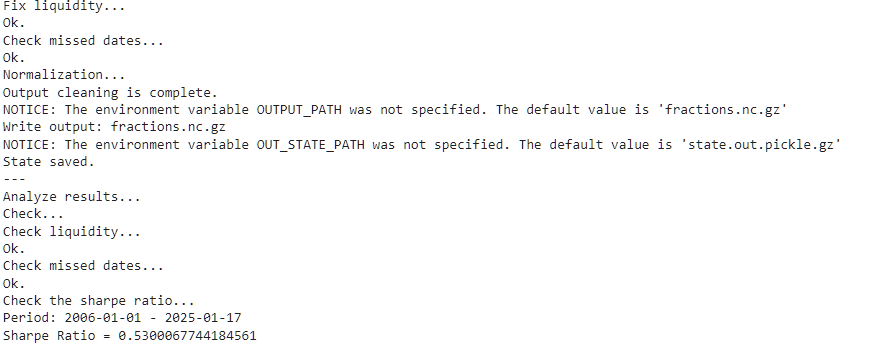
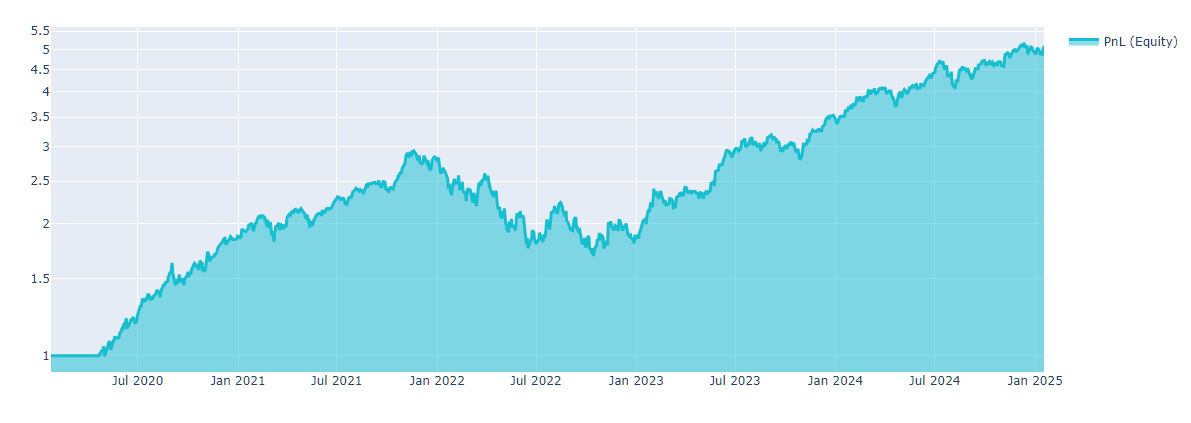
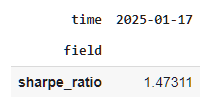

### 2. Código

In [ ]:
from sklearn.tree import DecisionTreeRegressor

def get_model():
    # Using DecisionTreeRegressor as a simpler model to reduce predictive power slightly
    model = DecisionTreeRegressor(
        max_depth=5,  # Limit the depth to reduce complexity and overfitting
        min_samples_split=10,  # Require more samples per split for reduced variance
        random_state=42
    )
    return model


In [ ]:
#ASSETS
import qnt.data as qndata

stock_data = qndata.stocks_load_spx_data(
    tail=365 * 5,
    assets=[
        'NAS:AAPL', 'NAS:AMZN', 'NAS:INTC', 'NAS:CSCO', 'NAS:PYPL',
        'NAS:QCOM', 'NAS:EBAY', 'NAS:SNPS', 'NAS:ISRG', 'NAS:ILMN',
        'NAS:LRCX', 'NAS:MRVL', 'NAS:MU', 'NAS:NTES', 'NAS:ORLY',
        'NAS:REGN', 'NAS:ROST', 'NAS:SGEN', 'NAS:SWKS', 'NAS:VRTX'
    ]
)


In [ ]:
def get_features(data):


    close_price = data.sel(field="close")
    trend = qnta.roc(qnta.lwma(close_price, 60), 1)
    trend = trend.assign_coords(field="trend")

    macd_line, signal_line, hist = qnta.macd(close_price)
    signal_line = signal_line.assign_coords(field="macd")

    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), close_price)
    volatility = volatility / close_price
    volatility = qnta.lwma(volatility, 14)
    volatility = volatility.assign_coords(field="volatility")

    k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), close_price, 14)
    d = d.assign_coords(field="stochastic_d")

    rsi = qnta.rsi(close_price)
    rsi = rsi.assign_coords(field="rsi")

    price = np.log(close_price.ffill("time").bfill("time").fillna(0))
    price = price.assign_coords(field="price")

    # Nuevas características
    # 1. Tasa de cambio logarítmica
    log_return = np.log(close_price / close_price.shift(time=1))
    log_return = log_return.assign_coords(field="log_return")

    # 2. Desviación estándar de retornos
    std_return = log_return.rolling(time=20).std()
    std_return = std_return.assign_coords(field="std_return")

    # 3. Índice de canal de commodities (CCI)
    typical_price = (data.sel(field="high") + data.sel(field="low") + close_price) / 3
    cci = (typical_price - typical_price.rolling(time=20).mean()) / (0.015 * typical_price.rolling(time=20).std())
    cci = cci.assign_coords(field="cci")

    # 4. Rango de precios
    price_range = data.sel(field="high") - data.sel(field="low")
    price_range = price_range.assign_coords(field="price_range")

    # 5. Índice de fuerza relativa (RFI)
    force_index = close_price.diff("time") * data.sel(field="vol")
    force_index = qnta.ema(force_index, 13)
    force_index = force_index.assign_coords(field="force_index")


    result = xr.concat(
        [trend, signal_line, volatility, d, rsi, price, log_return, std_return, cci, price_range, force_index],
        dim="field"
    )

    return result.transpose("time", "field", "asset")
